# Whoop! Whoop!

Phil 4:13 You did it!

In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import tree
# import graphviz
from sklearn import metrics 

%matplotlib inline

In [136]:
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

In [137]:
raw = pd.read_csv('../train.csv')
working_df = raw
# raw.tail(10)
raw.shape
working_df = raw

In [138]:
working_df.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

# Feature Engineeering

 ### Dealing with N/a 's
 List all of the columns that have N/a as an option

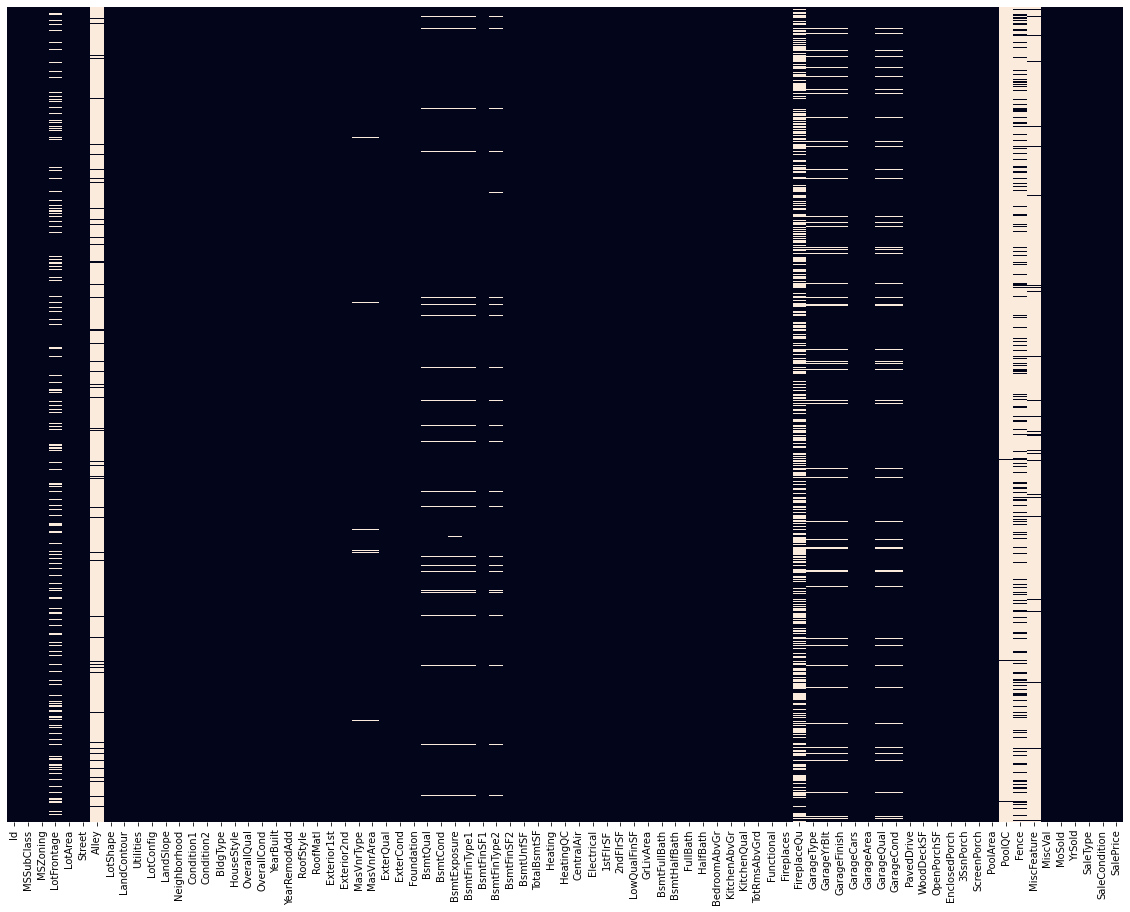

In [139]:
raw.isnull()
heatmap, ax2 = plt.subplots(figsize = (20,15))
# ax2=sns.heatmap(raw.isnull(),yticklabels=False,cbar=False,cmap='viridis') #cmap='YlGnBu
ax2=sns.heatmap(raw.isnull(),yticklabels=False,cbar=False)

## N/A COLUMN NAMES
* LotFrontage: Linear feet of street connected to property
* Alley 
    *  = No alley access
* MasVnrType: Masonry veneer type
    * 
* MasVnrArea
* BsmtQual
* BsmtCond
* BsmtExposure
* BsmtFinType1
* BsmtFinType2
* Electrical
* FireplaceQu
* GarageType
* GarageYrBlt
* GarageFinish
* GarageQual
* GarageCond
* PoolQC
* Fence
* MiscFeature

In [140]:
# Note:
# In each column the N/a means something different. To get the correct data meaning 
# we need to properly replace the N/a values with their corresponding meaning
# researching the column category (ie. Lot frontage) may be neccessary to find that desired cooresponding value

# Functions used in notebook

In [141]:
def fixNa(df, stage):
    # correct mislabled NAs
    naMeanings = {
        "LotFrontage":0 ,"Alley": "notIncluded","MasVnrType": "notIncluded",
        "BsmtQual": "notIncluded","BsmtCond":"notIncluded",
        "BsmtExposure": "notIncluded","BsmtFinType1": "notIncluded",
        "BsmtFinType2": "notIncluded","FireplaceQu":"notIncluded",
        "GarageType": "notIncluded","GarageYrBlt": "notIncluded",
        "GarageFinish": "notIncluded","GarageQual": "notIncluded",
        "GarageCond": "notIncluded","PoolQC": "notIncluded",
        "Fence": "notIncluded","MiscFeature": "notIncluded"
    }
    
    for col in naMeanings:
        df[col].fillna(naMeanings[col], inplace=True)
    
    # remove actual NAs
    if stage == "training":
        df.dropna(axis=0, inplace = True)
        
    
    return df

In [142]:
corr_val = -.5

# return df with the top features to train model
def feature_selecting_prep(df, target_value):
    #df of target correlation values
    # target_corr = df.corr()[[target_value]].sort_values(by=target_value, ascending=False)
    target_corr = df.corr()[[target_value]]
    # find features w/ corr value greater than/= to .5 w/ the target 
    top_feat = target_corr.loc[target_corr[target_value] >=corr_val] 
    
    # find these important columns/features using the entire working data set
    ready_df = df[top_feat.index.tolist()]
    
    return ready_df
# feature_selecting_prep(working_df, 'SalePrice')

In [143]:
def feature_selecting(df,columns_list):
    for feature in df.columns:
        if feature not in columns_list:
            df.drop(feature, inplace=True, axis=1)
            # print(df.columns)
    return df

In [144]:
def separate_feature_data_types(df):
        ## separate features types
    not_strings = []
    categorical_features = []
    for i in df.columns:
        if df[i].dtype == 'int64':
            not_strings.append(i)
        elif df[i].dtype == 'float64':
            not_strings.append(i)
        else:
            categorical_features.append(i)

    all_feature_types = {} # all features
    num_features = {} # only numberical features
    cat_features = {} # onlt categorical features
    
    ## store feature type and unique categories counts for categorical features
    for i in categorical_features:
        info_data = []
        info_data.append(df[i].nunique())
        info_data.append(df[i].dtype)
        all_feature_types[i] = info_data
        cat_features[i] = info_data

    for i in not_strings:
        info_data = []
        info_data.append(df[i].nunique())
        info_data.append(df[i].dtype)
        all_feature_types[i] = info_data
        num_features[i] = info_data

    return all_feature_types, cat_features, num_features


# feature_info, cat_feature_info ,num_feature_info = separate_feature_data_types()
# for key in cat_feature_info:
    # print("Feature:",key, "   Options for Category:",cat_feature_info[key][0], "   dtype:",cat_feature_info[key][1] )

In [165]:
# feature_info, cat_feature_info ,num_feature_info = separate_feature_data_types(working_df)

# for key in cat_feature_info:
#     print("Feature:",key, "   Options for Category:",cat_feature_info[key][0], "   dtype:",cat_feature_info[key][1] )

In [146]:
# def find_features_for_one_hot_encoding():
#     one_hot_features = []
#     for i in feature_info.keys():
#         if feature_info[i][0] == 2:
#             one_hot_features.append(i)
        
#     print(one_hot_features)
#     # print(one_hot_features)
#     return one_hot_features
# # one_hot_features = find_features_for_one_hot_encoding()

In [147]:
working_df["LotShape"].unique()

array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object)

In [219]:
def category_info(df):
# removed: 'OverallQual','OverallCond', 'MSSubClass' b/c they had numbers already 
    ordinal = {'Alley':['Pave','Grvl','notIncluded'],
               'LotShape':['Reg','IR1','IR2','IR3'],
               'LandSlope':['Gtl','Mod','Sev'],
               'ExterQual':['Ex','Gd','TA','Fa','Po'],
               'ExterCond':['Ex','Gd','TA','Fa','Po'],
               'BsmtQual':['Ex','Gd','TA','Fa','Po','notIncluded'],
               'BsmtCond':['Ex','Gd','TA','Fa','Po','notIncluded'],
               'BsmtExposure':['Gd','Av','Mn','No','notIncluded'],
               'BsmtFinType1':['GLQ','ALQ','BLQ','Rec','LwQ','Unf','notIncluded'],
               'BsmtFinType2': ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','notIncluded'],
               'HeatingQC':['Ex','Gd','TA','Fa','Po'],
               'KitchenQual':['Ex','Gd','TA','Fa','Po'],
               'Functional':['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal'],
               'FireplaceQu':['Ex','Gd','TA','Fa','Po','notIncluded'],
               'GarageFinish':['Fin','RFn','Unf','notIncluded'], 
               'GarageQual':['Ex','Gd','TA','Fa','Po','notIncluded'],
               'GarageCond':['Ex','Gd','TA','Fa','Po','notIncluded'],
               'PavedDrive':['Y','P','N'],
               'PoolQC':['Ex','Gd','TA','Fa','notIncluded']}
    
    nonordinal = ['MSZoning','Street','LandContour','Utilities','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','Electrical','GarageType','Fence','MiscFeature','SaleType' ,'SaleCondition']
    
    
    # i need the category options (by rank) for the ordinal features
    ordinal_list = []
    ordinal_feat = []
    for i in ordinal:
        ordinal_list.append(ordinal[i])
        ordinal_feat.append(i)
        
    return ordinal_list, ordinal_feat, nonordinal
# a,b,c = category_info(working_df)
# a[0],b[0]
    

In [220]:
working_df=raw

In [221]:
ord_feat = ['MSZoning','Street','LandContour','Utilities','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','Electrical','GarageType','Fence','MiscFeature','SaleType' ,'SaleCondition']
# X= working_df[ord_feat]
# oc = OrdinalEncoder(categories=ord_list)
# ord_transformed =  oc.fit_transform(X)
# ord_transformed

ohe = OneHotEncoder(handle_unknown='ignore')
X = working_df[ord_feat]
new_features = ohe.fit_transform(X).toarray()
feature_labelss = ohe.categories_ # multiple arrays of categories
# feature_labels = np.array(feature_labelss).flatten() # one array of all categories
# updated_features = pd.DataFrame(new_features, columns=feature_labels)
# updated_features
new_features
feature_labelss
    

[array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object),
 array(['Grvl', 'Pave'], dtype=object),
 array(['Bnk', 'HLS', 'Low', 'Lvl'], dtype=object),
 array(['AllPub', 'NoSeWa'], dtype=object),
 array(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'], dtype=object),
 array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
        'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
        'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
        'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
        'Veenker'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe',
        'RRNn'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn'],
       dtype=object),
 array(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'], dtype=object),
 array(['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story',
        'SFoyer', 'SLvl'], dtype=object),
 array(['Flat', 'Gable', 'Ga

In [210]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# encode categorical features
def encode_cats(df):
    
    # COULD BE USEFUL LATER
    # get list of categorical features only
    # all, cat, numer = separate_feature_data_types(df)
    # cat_list = []
    # for i in cat:
    #     cat_list.append(i)   

    # separtate ordinal cat and non-ordinal one
    ord_list, ord_feat, nonord_feat = category_info(df)
    
    ###### ORDINAL ENCODING ###########
    X = df[ord_feat]
    oc = OrdinalEncoder(categories=ord_list)
    ord_transformed =  oc.fit_transform(X)
    df[ord_feat]= ord_transformed
    ###### 1-HOT ENCODING ###########
    ##### Frequency Encoding ###########

    # feature_labels = np.array(feature_labelss).flatten() # one array of all categories
    # # updated_features = pd.DataFrame(new_features, columns=feature_labels)
    
    ohe = OneHotEncoder(handle_unknown='ignore')
    X = df[nonord_feat]
    new_features = ohe.fit_transform(X).toarray()
    feature_labelss = ohe.categories_ # multiple arrays of categories
    feature_labels = np.array(feature_labelss).flatten() # one array of all categories
    updated_features = pd.DataFrame(new_features, columns=feature_labels)
    
    # print(feature_labelss)
    # print()
    # print(feature_labels)
    
    # # enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
    # # # enc.get_feature_names_out(['gender', 'group'])
    # # return updated_features

encode_cats(working_df)
# c

array([[2., 0., 0., ..., 2., 0., 4.],
       [2., 0., 0., ..., 2., 0., 4.],
       [2., 1., 0., ..., 2., 0., 4.],
       ...,
       [2., 0., 0., ..., 2., 0., 4.],
       [2., 0., 0., ..., 2., 0., 4.],
       [2., 0., 0., ..., 2., 0., 4.]])

In [175]:
working_df

In [160]:
def preprocessing(df, status):
    df = fixNa(df,status)
    
    if status == "training":
        #choose the best numberical features
        target_value = "SalePrice"
        
        df = feature_selecting_prep(df, target_value)
        top_features_df = feature_selecting_prep(working_df, target_value)
        
        good_columns = []
        for c in top_features_df.columns:
            good_columns.append(c)
        #need to check if i still need this
        num_features = feature_selecting(working_df, good_columns)
        df = num_features
    
    df = encode_cats(df)
    
    return df

In [153]:
# # show me the features that are correlated with Target
target_value = "SalePrice"
top_features_df = feature_selecting_prep(working_df, target_value)

good_columns = []
for c in top_features_df.columns:
    good_columns.append(c)

### End of notebook functions

In [ ]:
heatmap, ax2 = plt.subplots(figsize = (20,15))
# ax2=sns.heatmap(raw.isnull(),yticklabels=False,cbar=False,cmap='viridis') #cmap='YlGnBu
ax2=sns.heatmap(working_df.isnull(),yticklabels=False,cbar=False)

In [ ]:
# now lets feature engeneer!
"""
Recap:
- all NAs have been removed but when i replaced empty lot frontage values with 0 we now kinda have a lot of outliers
-- instead of using 0 I'll ues the mean of that feature
What's next:
- graph a corrilation plot to get rid of the corrilated features
- Handle categorical features (there's a bunch but you got it)
--- ones with only 2 options use 1-hot encoding
--- ones with 3+ options use target encoding ...provided it doesnt need the target column 
- Normalize the data

- Split the data
- train the model
- test it!! and repeat
"""

In [ ]:
plt.figure(figsize=(16, 10))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(working_df.corr(), dtype=np.bool))
sns.heatmap(working_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='YlGnBu')


In [62]:
# # visualize what features the model is using based off of feature_selecting function
# def checkCorrStat(df,target_value, corr_val):
#     target_corr = df.corr()[[target_value]].sort_values(by=target_value, ascending=False)
#     top_feat = target_corr.loc[target_corr[target_value] >=corr_val] 
    
#     plt.figure(figsize=(8, 12))
#     heatmap = sns.heatmap(top_feat, vmin=-1, vmax=1, annot=True, cmap='BrBG')
#     heatmap.set_title('Features Correlating with '+ target_value, fontdict={'fontsize':18}, pad=16);

# checkCorrStat(working_df, "SalePrice", corr_val)
# # checkCorrStat(working_df, "OverallQual", -.5)


# Preprocessing Starts Here

In [161]:
# working_df = preprocessing(working_df,"training")
working_df = preprocessing(working_df,"testing")

# pd.unique(working_df["Alley"])
working_df

In [63]:
y = working_df['SalePrice']
#don't forget this step
X = working_df.drop(['SalePrice', 'Id'], axis =1)

In [64]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,notIncluded,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,notIncluded,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,notIncluded,notIncluded,notIncluded,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,notIncluded,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,notIncluded,notIncluded,notIncluded,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,notIncluded,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,notIncluded,notIncluded,notIncluded,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,notIncluded,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,notIncluded,notIncluded,notIncluded,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,notIncluded,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,notIncluded,notIncluded,notIncluded,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,notIncluded,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,notIncluded,notIncluded,notIncluded,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,Pave,notIncluded,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,notIncluded,MnPrv,notIncluded,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,Pave,notIncluded,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,notIncluded,GdPrv,Shed,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,Pave,notIncluded,Reg,Lvl,AllP

In [65]:
y.shape
X.shape


(1460, 79)

# Training

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

ValueError: could not convert string to float: 'RL'

In [67]:
train_score = regressor.score(X_train, y_train) 
test_score = regressor.score(X_test, y_test)

ValueError: could not convert string to float: 'RL'

# Prediction

In [673]:
# the real test data
test_data_raw = pd.read_csv('../test.csv')

test_data = preprocessing(test_data_raw)
test_data = feature_selecting(test_data,good_columns)
test_data_id = test_data['Id']
test_data_id
pred_score = regressor.predict(test_data.drop('Id', axis=1))


In [674]:
q = test_data['Id'].tolist
w = pd.DataFrame(data =test_data['Id'], columns=["Id"])
p=pd.DataFrame(pred_score,columns=["SalePrice"])

print(w.shape)
print(p.shape)

# w = w.append(p, ignore_index = False) # how to add rows...not columns
# w = w.join([p])
w["SalePrice"]=p['SalePrice'].values

(1432, 1)
(1432, 1)


In [675]:
final_submission = w
final_submission

,Id,SalePrice
0,1461,119465.292172
1,1462,162438.507496
2,1463,171079.901630
3,1464,200046.759808
4,1465,196036.331227
...,...,...
1454,2915,54008.881291
1455,2916,63929.075373
1456,2917,175459.671693
1457,2918,102463.546676


In [676]:
final_submission.to_csv("submission.csv",index=False)

ImportError: cannot import name 'CompressionOptions' from 'pandas._typing' (/opt/anaconda3/lib/python3.7/site-packages/pandas/_typing.py)

# Test Time!

In [528]:
# record your progress with the model
from datetime import datetime

file1 = open("scoring.txt","a")#append mode
message = str(datetime.now().date()) + "\n Training Score " + str(train_score) + "\n Test Score " + str(test_score) +  "\n Corrilation Value " + str(corr_val) + "\n \n"
file1.write(message)
file1.close()


# regressor.coef_
# regressor.intercept_

In [311]:
str(datetime.now().date())

'2022-01-16'

In [312]:
# sns.distplot(working_df['SalePrice'], kde = False, color ='red', bins = 30)

In [ ]:
# just found out!!!
# heatmap only works for numerical data so ...i've been trainng and testing without my categorical features ..oops

# Now:
# 1. enter submission just to see where we are
# 2. one-hot-encode categories and combine with high numerical ones
# 3. check score at this time
# 4. remove outliers
# 5. normalize the data
# 6. Rest like Jesus on the 7th day because.... you're finished!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
